In [1]:
!apt-get update
!apt-get install -y swig
!pip install "gymnasium[box2d]"
!pip install stable-baselines3

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,201 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,842 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,573 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-

In [5]:
import gymnasium as gym

import cv2
import numpy as np

from IPython.display import Video

from stable_baselines3 import DQN, PPO, A2C, DDPG, SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
env = gym.make("LunarLander-v3", render_mode="rgb_array", )

env = gym.wrappers.RecordVideo(env=env, video_folder="./lunarLander1")

observation, _ = env.reset()

done = False

while not done:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, _ = env.step(action)
    env.render()

    done = terminated or truncated

env.close()


/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [ ]:
Video('./lunarLander1/rl-video-episode-0.mp4', embed=True, width=600)

All the videos and trained models can be found [here](https://drive.google.com/drive/folders/1jc2S7ThC-ZI_WsXA98L9dyPjXSNaj0rl?usp=drive_link)

# Helping functions

In [ ]:
def train_model(
    model_name: str, # "DQN", A2C, PPO, SAC, DDPG
    total_timestamps: int = 100_000,
    continuous_action_space = False,
    **kwargs,
  ):
    train_env = Monitor(gym.make("LunarLander-v3", render_mode= "rgb_array", continuous=continuous_action_space), filename=f"./logs/{model_name}_train_monitor")
    eval_env = Monitor(gym.make("LunarLander-v3", render_mode= "rgb_array", continuous = continuous_action_space), filename=f"./logs/{model_name}_train_monitor")

    observation, _ = train_env.reset()

    if model_name == "DQN":
      model = DQN("MlpPolicy", train_env, verbose=2,device="cuda", **kwargs)
    elif model_name == "PPO":
      model = PPO("MlpPolicy", train_env, verbose=2,device="cuda", **kwargs)
    elif model_name == "A2C":
      model = A2C("MlpPolicy", train_env, verbose = 2, device="cuda", **kwargs)
    elif model_name == "DDPG":
      model = DDPG("MlpPolicy", train_env, verbose = 2, device="cuda", **kwargs)
    elif model_name == "SAC":
      model = SAC("MlpPolicy", train_env, verbose = 2, device="cuda", **kwargs)

    parameters = "_".join(f"{key}:{value}" for key, value in kwargs.items())
    save_model_name = f"{model_name}_{parameters}"

    eval_callback = EvalCallback(
      eval_env,
      best_model_save_path=f"./logs/{save_model_name}/best_model",
      log_path=f"./logs/{save_model_name}/results",
      eval_freq=10_000,
      deterministic=True,
      render=False
    )

    model.learn(total_timesteps=total_timestamps)

    model.save(save_model_name)

    train_env.close()

    return model


In [ ]:
def record_video(model: DQN | A2C | PPO| DDPG | SAC, video_name: str, continuous_action_space: bool = False):

    env = gym.make("LunarLander-v3", render_mode="rgb_array", continuous = continuous_action_space)

    env = gym.wrappers.RecordVideo(env=env, video_folder=video_name)

    observation, _ = env.reset()

    done = False

    while not done:
        action, _states = model.predict(observation, deterministic=True)
        observation, reward, terminated, truncated, _ = env.step(action)
        env.render()

        done = terminated or truncated

    env.close()

    return Video(f"{video_name}/rl-video-episode-0.mp4", embed=True, width=600)

In [9]:

def evaluate_and_plot(model: DQN | PPO | SAC | A2C | DDPG, n_eval_episodes=50, continuous_action_space: bool = False, title="Model Evaluation"):
    env = gym.make("LunarLander-v3", render_mode="rgb_array", continuous = continuous_action_space)

    episode_rewards, episode_lengths = evaluate_policy(
        model,
        env,
        n_eval_episodes=n_eval_episodes,
        return_episode_rewards=True,
        deterministic=True
    )

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    median_reward = np.median(episode_rewards)
    min_reward = np.min(episode_rewards)
    max_reward = np.max(episode_rewards)

    print("\n" + "="*40)
    print(f"  DETAILED METRICS ({n_eval_episodes} episodes)")
    print("="*40)
    print(f"Mean Reward   : {mean_reward:.2f} +/- {std_reward:.2f}")
    print(f"Median Reward : {median_reward:.2f}")
    print(f"Min/Max Reward: {min_reward:.2f} / {max_reward:.2f}")
    print(f"Mean Length   : {np.mean(episode_lengths):.1f} steps")
    print("="*40 + "\n")

    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    plt.suptitle(f"{title} - {model.__class__.__name__}", fontsize=16)

    sns.histplot(episode_rewards, kde=True, ax=axes[0], color='blue', bins=15)
    axes[0].axvline(mean_reward, color='red', linestyle='--', label=f'Mean: {mean_reward:.1f}')
    axes[0].set_title("Distribution of Episode Rewards")
    axes[0].set_xlabel("Total Reward")
    axes[0].legend()

    sns.boxplot(y=episode_rewards, ax=axes[1], color='lightblue')
    axes[1].set_title("Reward Spread (Box Plot)")
    axes[1].set_ylabel("Total Reward")

    plt.tight_layout()
    plt.show()



# Value based
I decided to start with Q-learning, as it is the most diverse one, even at the cost of being slow to train.

100_000 timestamps, learning_rate 0.0001, buffer_size 1000000, gamma 0.99, exploration_ration = 0.1

In [ ]:
dqn_base_kwargs = {
    "learning_rate" : 0.0001,
    "buffer_size": 1000000,
    "gamma": 0.99,
    "exploration_fraction": 0.1,
}

model_dqn_base = train_model("DQN",  **dqn_base_kwargs)

Using cuda device
Wrapping the env in a DummyVecEnv.
100000
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 76.5     |
|    ep_rew_mean      | -160     |
|    exploration_rate | 0.971    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1370     |
|    time_elapsed     | 0        |
|    total_timesteps  | 306      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.41     |
|    n_updates        | 51       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80.9     |
|    ep_rew_mean      | -170     |
|    exploration_rate | 0.939    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1159     |
|    time_elapsed     | 0        |
|    total_timesteps  | 647      |
| train/              |          |
|    learning_rate    | 0.0001

In [ ]:
record_video(model_dqn_base, "dqn_base_video")

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/dqn_base_video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



  DETAILED METRICS (50 episodes)
Mean Reward   : 39.90 +/- 131.05
Median Reward : -7.10
Min/Max Reward: -243.89 / 276.15
Mean Length   : 451.0 steps



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


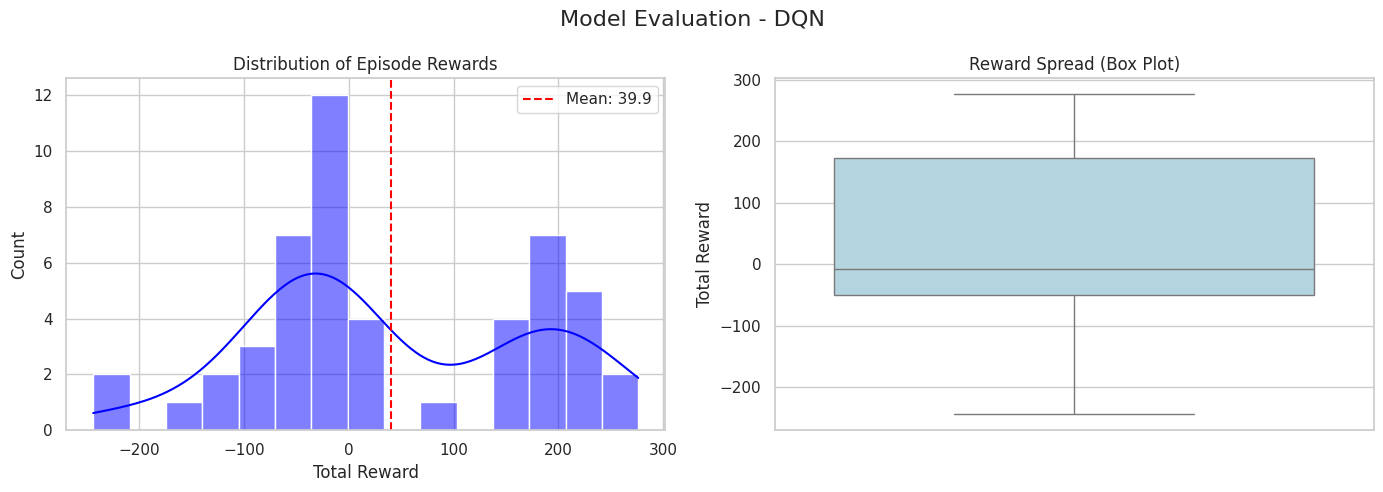

In [10]:
evaluate_and_plot(DQN.load("/content/dqn_mlp_lander.zip"))

Lander lands almost at the right spot. Perphaps it should have more eploration. We can see that standard deviation of reward is very high, even though average reward is positive.

70_000 timestemps, gamma 0.7

In [ ]:
dqn_slower_learner_kwargs = {
    "learning_rate" : 0.0001,
    "buffer_size": 1000000,
    "gamma": 0.7,
    "exploration_fraction": 0.1,
}

model_dqn_slower_learner = train_model("DQN",  total_timestamps=70_000, **dqn_slower_learner_kwargs)

Using cuda device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91       |
|    ep_rew_mean      | -280     |
|    exploration_rate | 0.951    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1361     |
|    time_elapsed     | 0        |
|    total_timesteps  | 364      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.41     |
|    n_updates        | 65       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92       |
|    ep_rew_mean      | -240     |
|    exploration_rate | 0.9      |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1184     |
|    time_elapsed     | 0        |
|    total_timesteps  | 736      |
| train/              |          |
|    learning_rate    | 0.0001   |
| 

In [ ]:
record_video(model_dqn_slower_learner, "dqn_slower_learner")

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



  DETAILED METRICS (50 episodes)
Mean Reward   : -110.23 +/- 108.18
Median Reward : -144.76
Min/Max Reward: -256.10 / 225.99
Mean Length   : 286.6 steps



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


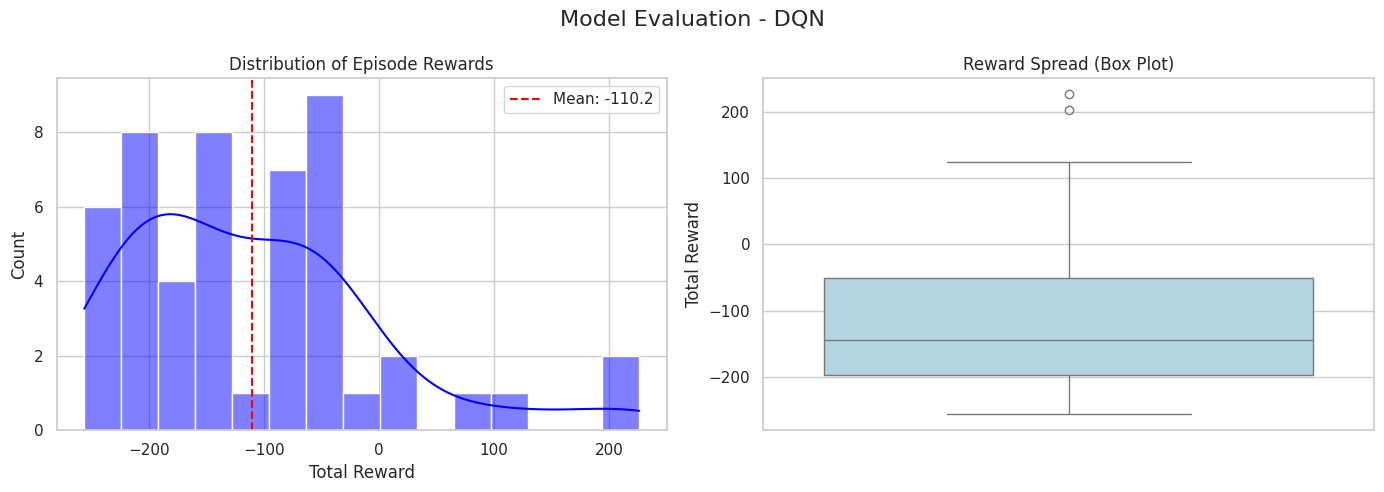

In [11]:
evaluate_and_plot(DQN.load("/content/DQN_learning_rate_0.0001_buffer_size_1000000_gamma_0.7_exploration_fraction_0.1"))

As the previous configuration performd almost well, I want to see whether decreasing parameters that correspond to how "fast" and "hard" it learns. As we see it cannot land at all.

Retarded lunar lander, but ver altruistic!
70_000 timestemps, gamma 0.7, "exploration_fraction": 0.4

In [ ]:
dqn_altruism_kwargs = {
    "learning_rate" : 0.0001,
    "buffer_size": 1000000,
    "gamma": 0.7,
    "exploration_fraction": 0.4,
}

model_dqn_altruism = train_model("DQN",  total_timestamps=70_000, **dqn_altruism_kwargs)

Using cuda device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | -191     |
|    exploration_rate | 0.985    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1289     |
|    time_elapsed     | 0        |
|    total_timesteps  | 437      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.53     |
|    n_updates        | 84       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.1     |
|    ep_rew_mean      | -204     |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1187     |
|    time_elapsed     | 0        |
|    total_timesteps  | 785      |
| train/              |          |
|    learning_rate    | 0.0001   |
| 

In [ ]:
record_video(model_dqn_altruism, "dqn_altruist")

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



  DETAILED METRICS (50 episodes)
Mean Reward   : -103.39 +/- 170.09
Median Reward : -128.51
Min/Max Reward: -319.20 / 239.97
Mean Length   : 428.7 steps



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


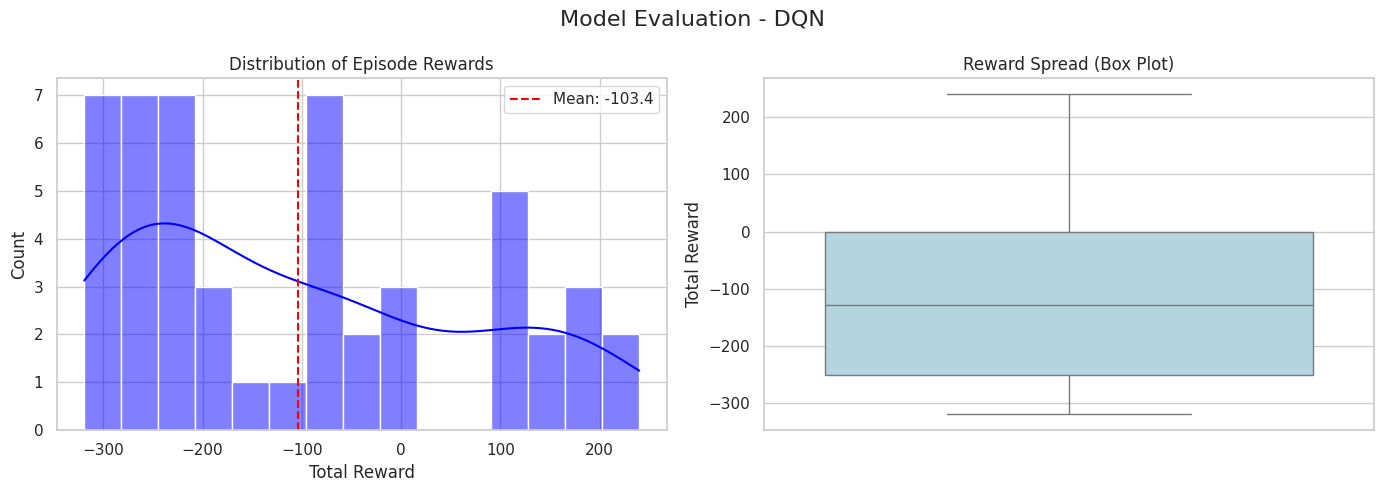

In [13]:
evaluate_and_plot(DQN.load("/content/DQN_learning_rate_0.0001_buffer_size_1000000_gamma_0.7_exploration_fraction_0.4"))

Increasing exploration rate makes lander learn to land on its legs. However, parameters that make it "dumber" lead it to crash. Thus, average reward is negative.

As was mentioned before I assume exploration is not enough

We have tested altruistic, even though stupid lander. Let us test lunar lander with slight ADHD -- set buffer_size twice smaller.

In [ ]:
dqn_adhd_kwargs = {
    "learning_rate" : 0.0001,
    "buffer_size": 500000,
    "gamma": 0.99,
    "exploration_fraction": 0.1,
}

model_dqn_adhd = train_model("DQN",  total_timestamps=70_000, **dqn_adhd_kwargs)

Using cuda device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | -223     |
|    exploration_rate | 0.938    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1241     |
|    time_elapsed     | 0        |
|    total_timesteps  | 454      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.64     |
|    n_updates        | 88       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.8     |
|    ep_rew_mean      | -207     |
|    exploration_rate | 0.892    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1154     |
|    time_elapsed     | 0        |
|    total_timesteps  | 798      |
| train/              |          |
|    learning_rate    | 0.0001   |
| 

In [ ]:
record_video(model_dqn_adhd, "dqn_adhd")

Unfortunately I forgot to save the model, so I cannot test its metrics.

Based on my experiments I have the following conclusion:
Decreasing gamma and number of timestamps generally decreases performance of lander. However, even with lowered gamma and timestamps number increasing exploration ratio gives better results, as lunar lander environment allows for aggressive strategies that RL-model with low exploration ratio cannot grasp.

Also decreasing buffer size did not lead to worse results. In my opinion this is due the fact that in my environment gravity used is low enough, thus lander does not needs information from long before.

# Policy Based
## Proximal Policy Optimization
Standard parameters:
- gamma 0.99
- gae_lambda 0.95
- n_steps 2048
- use_sde False
- clip_range 0.2

In [ ]:
ppo_base = {
    "gamma": 0.99,
    "gae_lambda" : 0.95,
    "n_steps":2048,
    "use_sde": False,
    "clip_range": 0.2,
}

model_ppo_base = train_model("PPO",  total_timestamps=200_000, **ppo_base)

Using cuda device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 92.5     |
|    ep_rew_mean     | -182     |
| time/              |          |
|    fps             | 554      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 94.8        |
|    ep_rew_mean          | -217        |
| time/                   |             |
|    fps                  | 496         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009041868 |
|    clip_fraction        | 0.0313      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | -0.00279    |
|    learning_rate        | 0.

In [ ]:
record_video(model_ppo_base, "ppo_base")

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



  DETAILED METRICS (50 episodes)
Mean Reward   : -65.00 +/- 26.52
Median Reward : -65.06
Min/Max Reward: -119.55 / 0.53
Mean Length   : 1000.0 steps



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


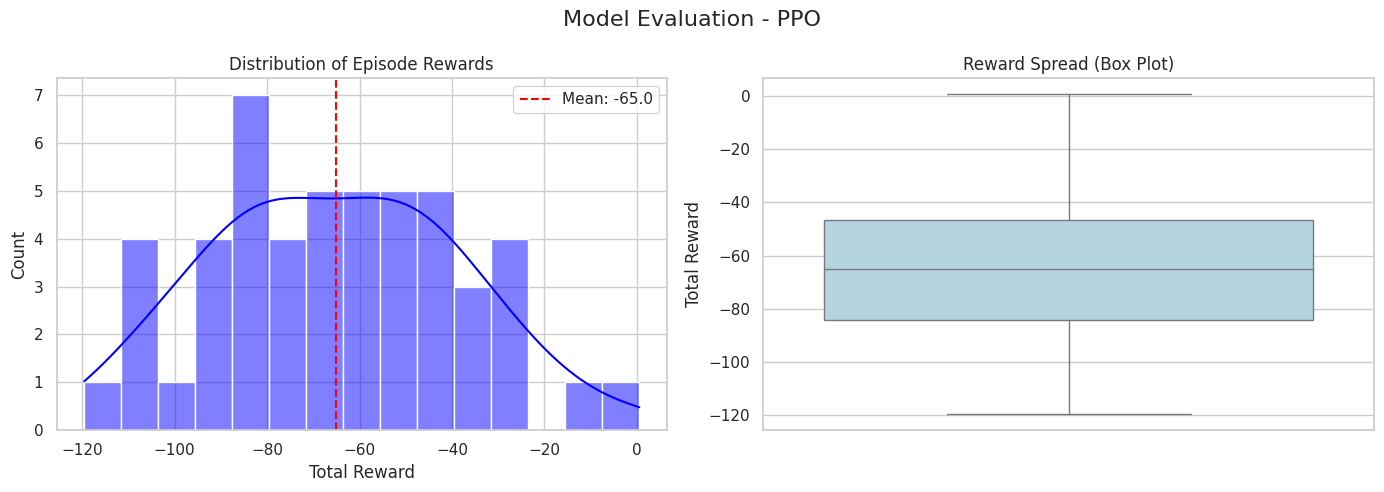

In [18]:
evaluate_and_plot(PPO.load("/content/PPO_gamma_0.99_gae_lambda_0.95_n_steps_2048_use_sde_True_clip_range_0.2"), continuous_action_space=True)


Even though lander lands, it can be seen that it is slightly off. It can bee seen from the fact that average reward is negative. However, because of the PPO nature we see that std of reward is much smaller. I suppose if I trained for more timestamps it would have learned better.

The main attribute of PPO is how it approaches expolartion-explotiation tradeoff problem. It does it by introdusing "cuttoff" when policy changed too much. It makes exploration process more smooth, thus maintaining stable performance algorithm, without fear of exploration that makes lander's "logic" unpredictable.
I want to make the clip range bigger, this will lead to higher exploration.

In [ ]:
ppo_higher_clip = {
    "gamma": 0.99,
    "gae_lambda" : 0.95,
    "n_steps":2048,
    "use_sde": False,
    "clip_range": 0.5,
}

model_ppo_higher_clip = train_model("PPO",  total_timestamps=200_000, **ppo_higher_clip)

Using cuda device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -188     |
| time/              |          |
|    fps             | 659      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 96.9        |
|    ep_rew_mean          | -179        |
| time/                   |             |
|    fps                  | 507         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010927937 |
|    clip_fraction        | 0           |
|    clip_range           | 0.5         |
|    entropy_loss         | -1.38       |
|    explained_variance   | -0.000241   |
|    learning_rate        | 0.

In [ ]:
record_video(model_ppo_higher_clip, "ppo_higher_clip")

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



  DETAILED METRICS (50 episodes)
Mean Reward   : 115.35 +/- 101.78
Median Reward : 147.24
Min/Max Reward: -155.82 / 236.43
Mean Length   : 665.9 steps



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


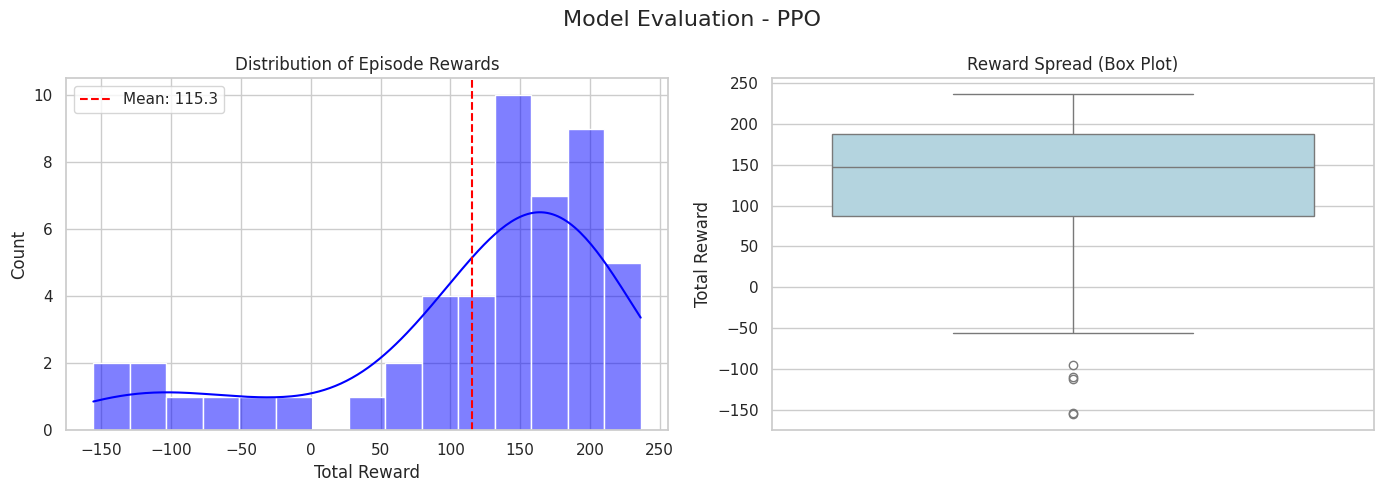

In [19]:
evaluate_and_plot(PPO.load("/content/PPO_gamma_0.99_gae_lambda_0.95_n_steps_2048_use_sde_False_clip_range_0.5"))

We can see, that this did not yielded a good result. My assumption is that big clipping range yielded disblance in policy that led lander to fly to far left.

The other way to increase coefficient near the entropy term.

In [ ]:
ppo_higher_ent = {
    "gamma": 0.99,
    "gae_lambda" : 0.95,
    "n_steps":2048,
    "use_sde": False,
    "clip_range": 0.2,
    "ent_coef":0.3,
}

model_ppo_higher_ent = train_model("PPO",  total_timestamps=200_000, **ppo_higher_ent)

Using cuda device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 92.6     |
|    ep_rew_mean     | -156     |
| time/              |          |
|    fps             | 593      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 94          |
|    ep_rew_mean          | -159        |
| time/                   |             |
|    fps                  | 493         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004209417 |
|    clip_fraction        | 0.0112      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.00439     |
|    learning_rate        | 0.

In [ ]:
record_video(model_ppo_higher_ent, "ppo_higher_ent")

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/ppo_higher_ent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



  DETAILED METRICS (50 episodes)
Mean Reward   : -45.34 +/- 57.66
Median Reward : -49.14
Min/Max Reward: -171.37 / 162.14
Mean Length   : 831.4 steps



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


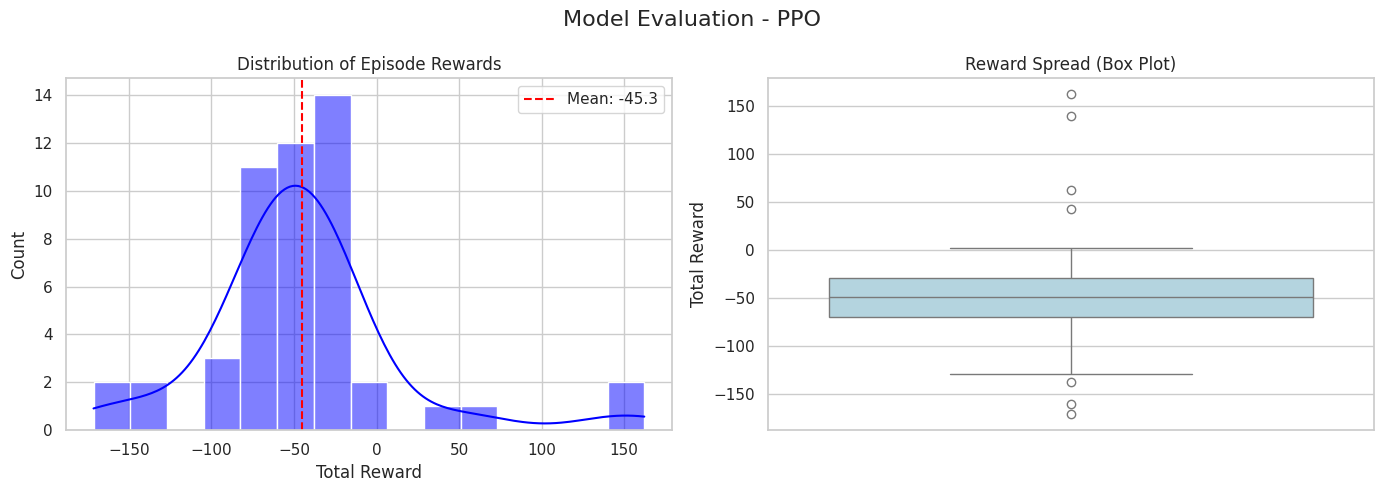

In [20]:
evaluate_and_plot(PPO.load("/content/PPO_gamma_0.99_gae_lambda_0.95_n_steps_2048_use_sde_False_clip_range_0.2_ent_coef_0.3"))

It is interesting, that in both cases when I increased clip range or entropy constant, lander, instead of trying to land from above, firstly lands on the ground and than "walks" on it. Because it is obviously easier.

In lunar lander our next actions depend on the previous ones. Especially on the momentum we have. Thus, it maybe be better if noise added to the outputted action was dependent on the action. It can be done by using generalized state dependent exploration instead of action noise exploration.

In [ ]:
ppo_gsde = {
    "gamma": 0.99,
    "gae_lambda" : 0.95,
    "n_steps":2048,
    "use_sde": False,
    "clip_range": 0.2,
    "use_sde": True,
}

model_ppo_gsde = train_model("PPO",  total_timestamps=200_000, continuous_action_space=True,**ppo_gsde)

Using cuda device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 191      |
|    ep_rew_mean     | -219     |
| time/              |          |
|    fps             | 498      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102          |
|    ep_rew_mean          | -252         |
| time/                   |              |
|    fps                  | 464          |
|    iterations           | 2            |
|    time_elapsed         | 8            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0053049875 |
|    clip_fraction        | 0.0303       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.32        |
|    explained_variance   | 0.00588      |
|    learning_r

In [ ]:
record_video(model_ppo_gsde, "ppo_gsde", continuous_action_space = True)

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:434: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



  DETAILED METRICS (50 episodes)
Mean Reward   : -68.27 +/- 37.39
Median Reward : -70.57
Min/Max Reward: -130.10 / 7.66
Mean Length   : 1000.0 steps



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


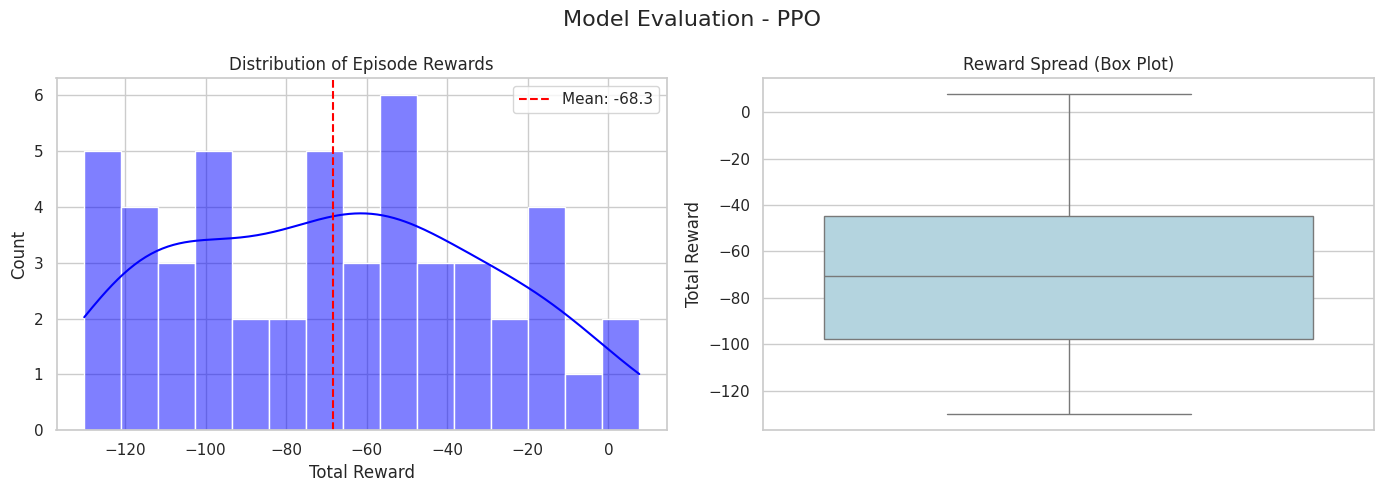

In [22]:
evaluate_and_plot(PPO.load("/content/PPO_gamma_0.99_gae_lambda_0.95_n_steps_2048_use_sde_True_clip_range_0.2"), continuous_action_space=True)

Because of the ocntinuous environment required for generalized state dependent exploration algorithm needs more time to learn, thus algorithm does not lands.

# Actor-critic
## A2C
Combination of policy based and agent based

In [ ]:
a2c_base = {
    "gae_lambda" : 1.00,
    "ent_coef": 0.0
}

model_a2c_base = train_model("A2C",  total_timestamps=150_000, **a2c_base)


Using cuda device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
|    value_loss         | 38.8     |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 102       |
|    ep_rew_mean        | -494      |
| time/                 |           |
|    fps                | 401       |
|    iterations         | 700       |
|    time_elapsed       | 8         |
|    total_timesteps    | 3500      |
| train/                |           |
|    entropy_loss       | -1.09     |
|    explained_variance | -0.000149 |
|    learning_rate      | 0.0007    |
|    n_updates          | 699       |
|    policy_loss        | -15.2     |
|    value_loss         | 162       |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 104       |
|    ep_rew_mean        | -506      |
| time/                 |           |
|    fps                | 404       |
|

In [ ]:
record_video(model_a2c_base, "a2c_base")

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/a2c_base folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:434: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(



  DETAILED METRICS (50 episodes)
Mean Reward   : 14.41 +/- 124.45
Median Reward : -44.74
Min/Max Reward: -94.28 / 303.46
Mean Length   : 805.8 steps



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


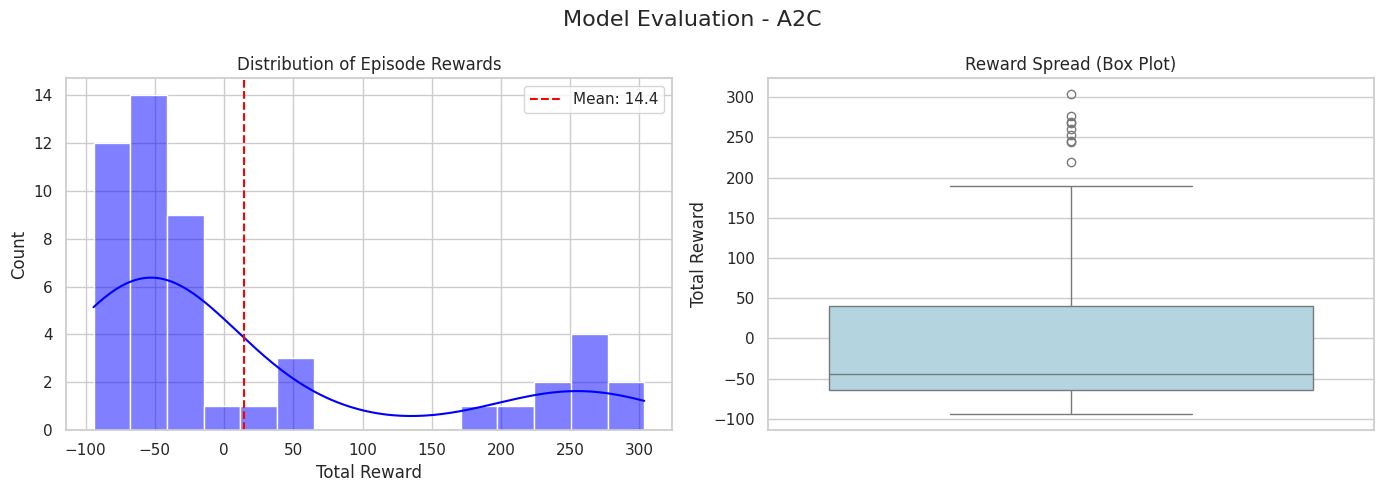

In [24]:
evaluate_and_plot(A2C.load("/content/A2C_gae_lambda_1.0_ent_coef_0.0"))

The agent flies to far away from the ground. My assumption that there is not enough exploration thus I decided to increase entropy.

In [ ]:
a2c_higher_ent = {
    "gae_lambda" : 1.00,
    "ent_coef": 0.5
}

model_a2c_higher_ent = train_model("A2C",  total_timestamps=150_000, **a2c_higher_ent)

Streaming output truncated to the last 5000 lines.
|    value_loss         | 6.2      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 126      |
|    ep_rew_mean        | -194     |
| time/                 |          |
|    fps                | 416      |
|    iterations         | 700      |
|    time_elapsed       | 8        |
|    total_timesteps    | 3500     |
| train/                |          |
|    entropy_loss       | -1.33    |
|    explained_variance | 0.0297   |
|    learning_rate      | 0.0007   |
|    n_updates          | 699      |
|    policy_loss        | 0.584    |
|    value_loss         | 0.652    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 126      |
|    ep_rew_mean        | -194     |
| time/                 |          |
|    fps                | 392      |
|    iterations         

In [ ]:
record_video(model_a2c_higher_ent, "a2c_higher_ent")

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



  DETAILED METRICS (50 episodes)
Mean Reward   : 144.26 +/- 117.21
Median Reward : 179.59
Min/Max Reward: -81.43 / 294.52
Mean Length   : 420.2 steps



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


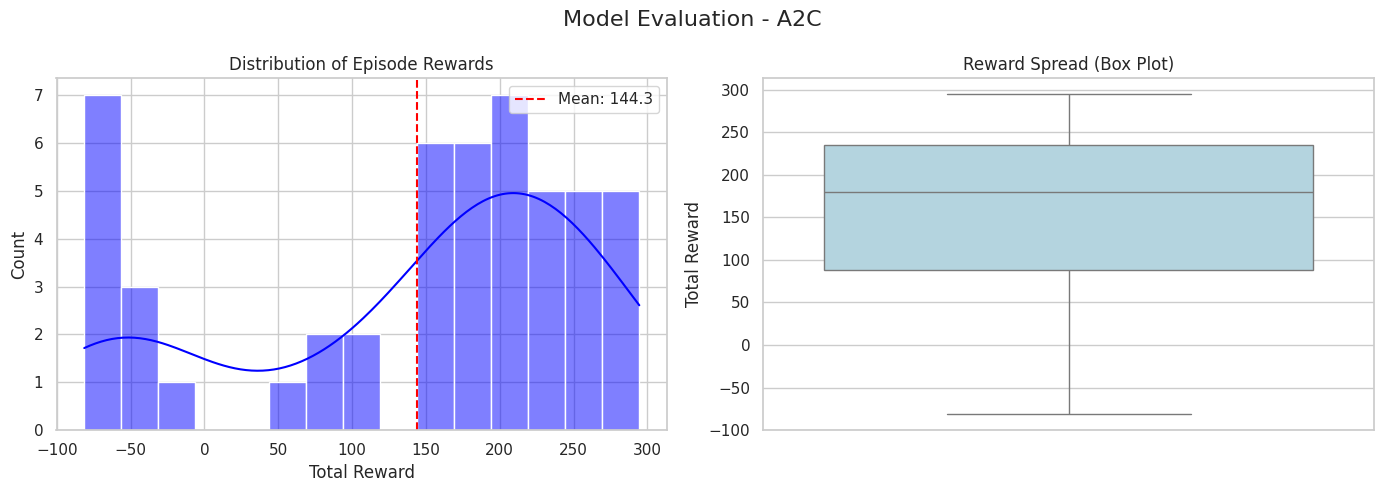

In [25]:
evaluate_and_plot(A2C.load("/content/A2C_gae_lambda_1.0_ent_coef_0.5"))

Now agent is on the ground, but not on the right place, so I will tune entropy down.

In [ ]:
a2c_lower_ent = {
    "gae_lambda" : 1.00,
    "ent_coef": 0.2
}

model_a2c_lower_ent = train_model("A2C",  total_timestamps=150_000, **a2c_lower_ent)

Streaming output truncated to the last 5000 lines.
|    value_loss         | 7.08e+03 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 139      |
|    ep_rew_mean        | -285     |
| time/                 |          |
|    fps                | 404      |
|    iterations         | 700      |
|    time_elapsed       | 8        |
|    total_timesteps    | 3500     |
| train/                |          |
|    entropy_loss       | -1.21    |
|    explained_variance | 0.00669  |
|    learning_rate      | 0.0007   |
|    n_updates          | 699      |
|    policy_loss        | 2.52     |
|    value_loss         | 8.15     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 139      |
|    ep_rew_mean        | -285     |
| time/                 |          |
|    fps                | 398      |
|    iterations         

In [ ]:
record_video(model_a2c_lower_ent, "a2c_lower_ent")

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



  DETAILED METRICS (50 episodes)
Mean Reward   : -7.59 +/- 120.27
Median Reward : -16.74
Min/Max Reward: -227.94 / 255.59
Mean Length   : 178.7 steps



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


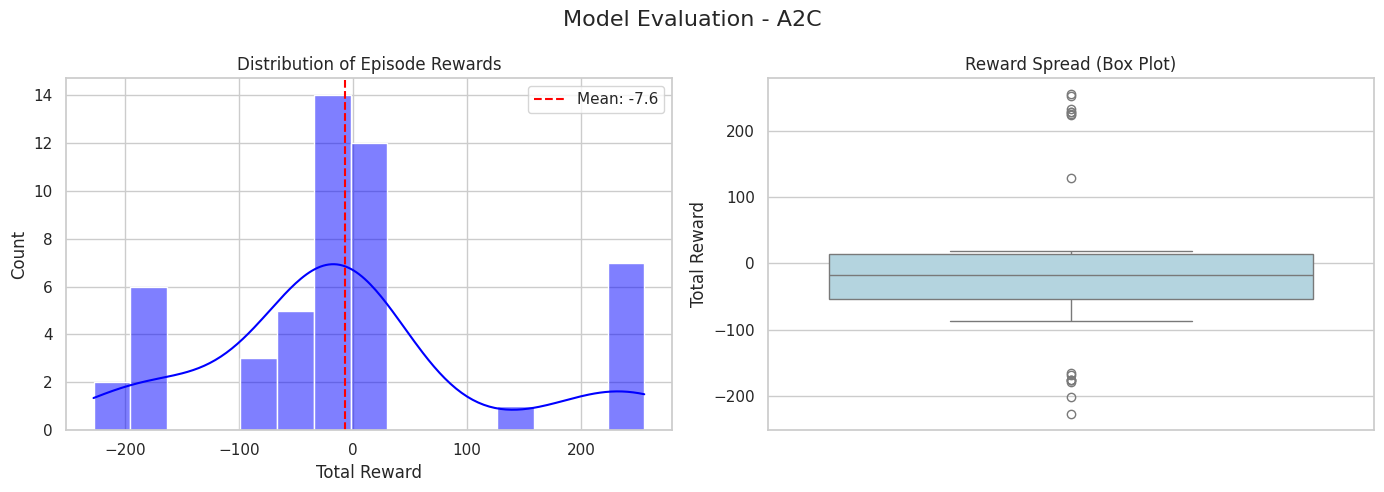

In [26]:
evaluate_and_plot(A2C.load("/content/A2C_gae_lambda_1.0_ent_coef_0.2"))

And my reasoning was correct :+)
What is interesting is that average reward is lower than in previous case, even though with higher entropy it lands far off the spot. I assume with in this experiment lander crashes because it lands faster.

I lowered gae labmda just to see how adding bias at the cost of variance will impact performance.

In [ ]:
a2c_lower_gae = {
    "gae_lambda" : 0.8,
    "ent_coef": 0.0
}

model_a2c_lower_gae = train_model("A2C",  total_timestamps=150_000, **a2c_lower_gae)

Streaming output truncated to the last 5000 lines.
|    value_loss         | 2.22     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 183      |
|    ep_rew_mean        | -292     |
| time/                 |          |
|    fps                | 371      |
|    iterations         | 700      |
|    time_elapsed       | 9        |
|    total_timesteps    | 3500     |
| train/                |          |
|    entropy_loss       | -1.34    |
|    explained_variance | -0.0155  |
|    learning_rate      | 0.0007   |
|    n_updates          | 699      |
|    policy_loss        | 0.537    |
|    value_loss         | 2.37     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 185      |
|    ep_rew_mean        | -289     |
| time/                 |          |
|    fps                | 375      |
|    iterations         

In [ ]:
record_video(model_a2c_lower_gae, "a2c_lower_gae")

## DDPG

A2C and DDPG are very similar because they both employ actor-critic architecture. But what is interesting in DDPG because it relies on the previous versions of policy, which helps to stabilize learning. It also has a buffer that gives memory as in DQN.

In [ ]:
ddpg_base = {
    "tau" : 0.005,
    "buffer_size" : 1000000,
}

model_ddpg_base = train_model("DDPG",  total_timestamps=50_000, continuous_action_space = True,**ddpg_base)

Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 105      |
|    ep_rew_mean     | -816     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 166      |
|    time_elapsed    | 2        |
|    total_timesteps | 419      |
| train/             |          |
|    actor_loss      | 16.5     |
|    critic_loss     | 76.5     |
|    learning_rate   | 0.001    |
|    n_updates       | 318      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 98.9     |
|    ep_rew_mean     | -807     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 147      |
|    time_elapsed    | 5        |
|    total_timesteps | 791      |
| train/             |          |
|    actor_loss      | 18.2     |
|    critic_loss     | 25.2     |
|    learning_rate   | 0.001 

In [ ]:
record_video(model_ddpg_base, "ddpg_base", continuous_action_space=True)

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:434: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



  DETAILED METRICS (50 episodes)
Mean Reward   : -177.90 +/- 85.21
Median Reward : -162.14
Min/Max Reward: -437.44 / -78.74
Mean Length   : 397.4 steps



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


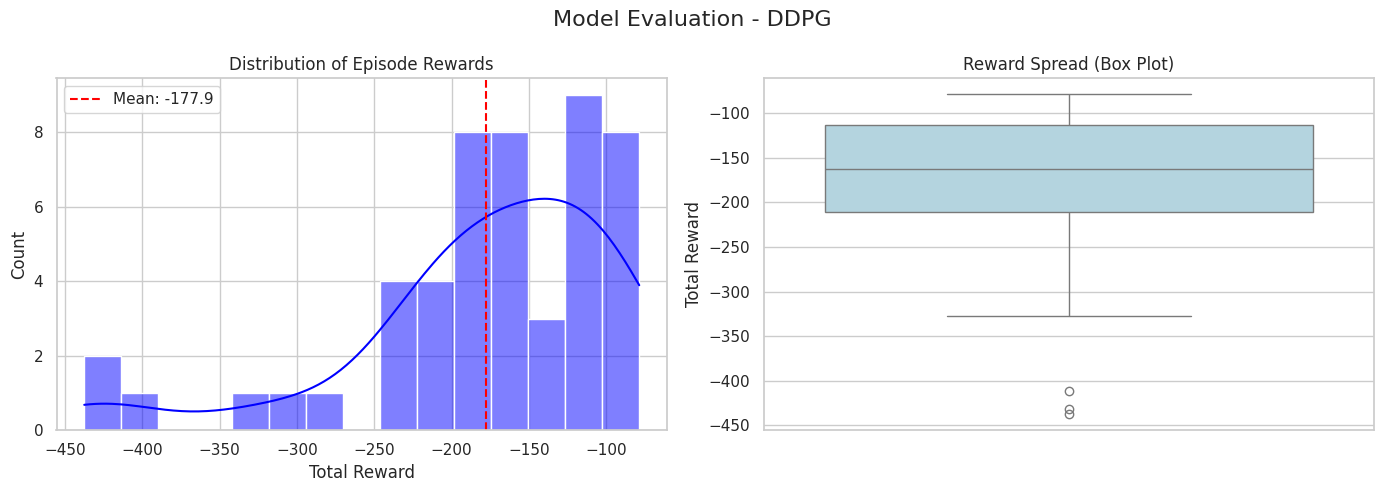

In [27]:
evaluate_and_plot(DDPG.load("/content/DDPG_tau_0.005_buffer_size_1000000"), continuous_action_space=True)

I want to test what will happen if we make the training less stable, by making old policies vanish quickier.

In [ ]:
ddpg_higher_tau = {
    "tau" : 0.01,
    "buffer_size" : 1000000,
}

model_ddpg_higher_tau = train_model("DDPG",  total_timestamps=50_000, continuous_action_space = True,**ddpg_higher_tau)

Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 104      |
|    ep_rew_mean     | -639     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 173      |
|    time_elapsed    | 2        |
|    total_timesteps | 417      |
| train/             |          |
|    actor_loss      | 23.8     |
|    critic_loss     | 49.5     |
|    learning_rate   | 0.001    |
|    n_updates       | 316      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 91       |
|    ep_rew_mean     | -836     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 152      |
|    time_elapsed    | 4        |
|    total_timesteps | 728      |
| train/             |          |
|    actor_loss      | 35.8     |
|    critic_loss     | 83.9     |
|    learning_rate   | 0.001 

In [ ]:
record_video(model_ddpg_higher_tau, "ddpg_higher_tau", continuous_action_space=True)

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



  DETAILED METRICS (50 episodes)
Mean Reward   : -1103.12 +/- 327.38
Median Reward : -1026.45
Min/Max Reward: -2186.05 / -720.09
Mean Length   : 87.9 steps



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


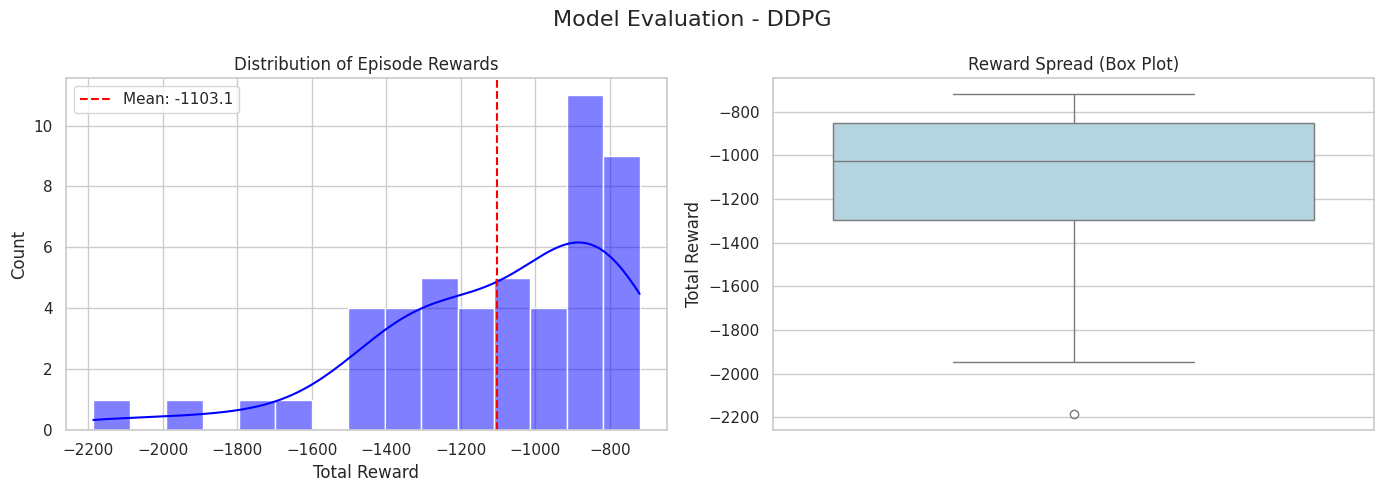

In [28]:
evaluate_and_plot(DDPG.load("/content/DDPG_tau_0.01_buffer_size_1000000"), continuous_action_space=True)

Similar to DQN, I assume we do not need such long context window, thus I try to shorten it.

In [ ]:
ddpg_smaller_buffer = {
    "tau" : 0.005,
    "buffer_size" : 500000,
}

model_ddpg_smaller_buffer = train_model("DDPG",  total_timestamps=50_000, continuous_action_space = True,**ddpg_smaller_buffer)

Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 98.5     |
|    ep_rew_mean     | -403     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 145      |
|    time_elapsed    | 2        |
|    total_timesteps | 394      |
| train/             |          |
|    actor_loss      | 3.68     |
|    critic_loss     | 42.6     |
|    learning_rate   | 0.001    |
|    n_updates       | 293      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 128      |
|    ep_rew_mean     | -396     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 141      |
|    time_elapsed    | 7        |
|    total_timesteps | 1023     |
| train/             |          |
|    actor_loss      | 5.2      |
|    critic_loss     | 31.6     |
|    learning_rate   | 0.001 

In [ ]:
record_video(model_ddpg_smaller_buffer, "ddpg_smaller_buffer", continuous_action_space=True)

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



  DETAILED METRICS (50 episodes)
Mean Reward   : -233.49 +/- 41.07
Median Reward : -240.90
Min/Max Reward: -297.18 / -106.52
Mean Length   : 326.7 steps



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


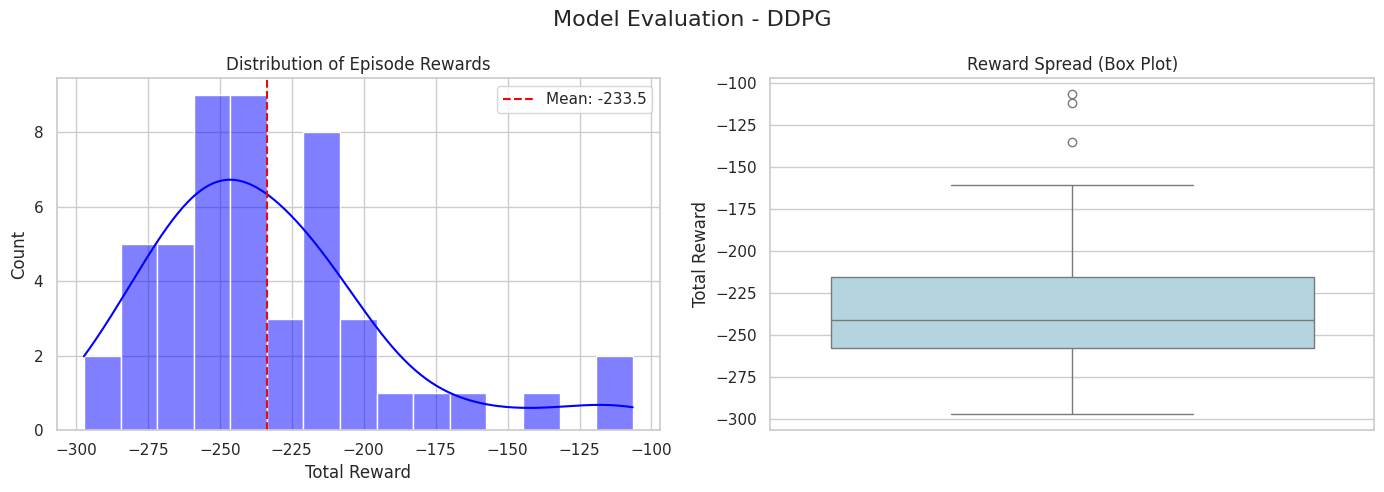

In [29]:
evaluate_and_plot(DDPG.load("/content/DDPG_tau_0.005_buffer_size_500000"), continuous_action_space=True)

### Why does not land?

DDPG trains much longer than other algorithms, thus I decreased number of timestamps, thus alogrithm does not have enough time to converge.

## SAC
SAC uses entropy to regularize policy changes. This is a clever solution, as entropy in general show's how much information something contains. And when using it for regularization it allows for big changes of some part of policy where it matters.

In [ ]:
sac_base = {
    "tau" : 0.005,
}

model_sac_base = train_model("SAC",  total_timestamps=50_000, continuous_action_space = True,**sac_base)

Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 159      |
|    ep_rew_mean     | -403     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 77       |
|    time_elapsed    | 8        |
|    total_timesteps | 635      |
| train/             |          |
|    actor_loss      | 1.89     |
|    critic_loss     | 2.63     |
|    ent_coef        | 0.857    |
|    ent_coef_loss   | -0.429   |
|    learning_rate   | 0.0003   |
|    n_updates       | 534      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 195      |
|    ep_rew_mean     | -276     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 78       |
|    time_elapsed    | 19       |
|    total_timesteps | 1560     |
| train/             |          |
|    actor_loss      | -2.22 

In [ ]:
record_video(model_sac_base, "sac_base", continuous_action_space=True)

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



  DETAILED METRICS (50 episodes)
Mean Reward   : -85.55 +/- 78.55
Median Reward : -64.07
Min/Max Reward: -477.69 / 7.64
Mean Length   : 869.2 steps



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


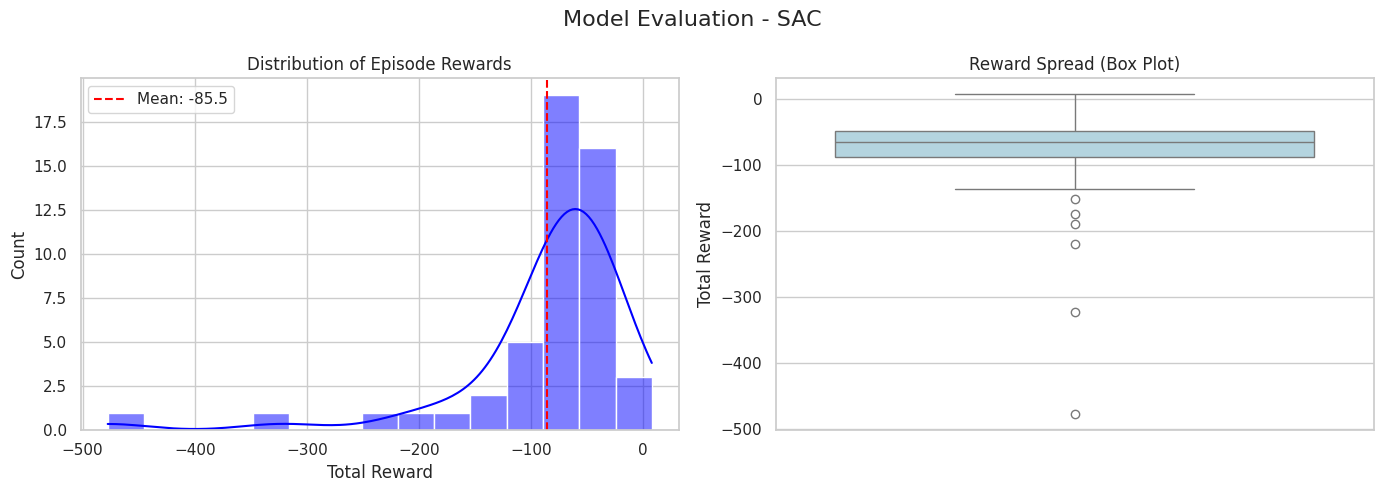

In [31]:
evaluate_and_plot(SAC.load("/content/SAC_tau_0.005"), continuous_action_space=True)

As I see, SAC does not have a lot of RL-like attributes. Most of them influence actually DL part of the algorithm.

In [ ]:
sac_lower_tau = {
    "tau" : 0.01,
}

model_sac_lower_tau = train_model("SAC",  total_timestamps=50_000, continuous_action_space = True,**sac_lower_tau)

Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 121      |
|    ep_rew_mean     | -227     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 95       |
|    time_elapsed    | 5        |
|    total_timesteps | 483      |
| train/             |          |
|    actor_loss      | -0.412   |
|    critic_loss     | 28.8     |
|    ent_coef        | 0.895    |
|    ent_coef_loss   | -0.325   |
|    learning_rate   | 0.0003   |
|    n_updates       | 382      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 130      |
|    ep_rew_mean     | -162     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 85       |
|    time_elapsed    | 12       |
|    total_timesteps | 1043     |
| train/             |          |
|    actor_loss      | -2.24 

In [ ]:
record_video(model_sac_lower_tau, "sac_lower_tau", continuous_action_space=True)

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



  DETAILED METRICS (50 episodes)
Mean Reward   : -34.87 +/- 46.35
Median Reward : -24.41
Min/Max Reward: -208.01 / 21.45
Mean Length   : 721.4 steps



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


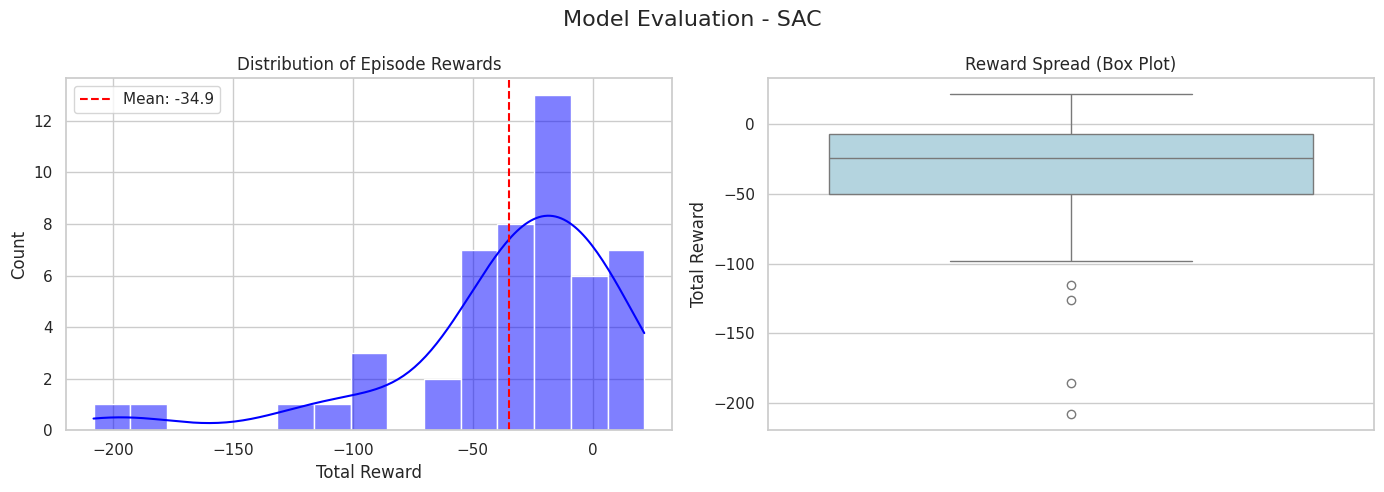

In [32]:
evaluate_and_plot(SAC.load("/content/SAC_tau_0.01"), continuous_action_space=True)

# Conclusions

In this work I tested 5 RL algorithms from 3 main domains: Policy based, Value based and Actor-Critic based.

Value based algorithms seem to be the most easy to understand and are the most RL-spirited (as they are overly reliant on the **value** ofreward).
I tested DQN which is advancement of Q-learning by using MLP instead of Q-table. Advantage of DQL is that it can be applied almost to any model, as all it needs are rewards. Disadvantage is obvious: requires discrete action space and is long to train, as it does not incorporate any knowledge about model.

Policy based algorithms instead of learning how good the action is directly learn how to act (policy). They do it by means of estimating probability distribution of each action on each state. Where actor's model (MLP in this work) acts as state -> distribution converter. This allows for continuous action space models and it really learns "stochastic" part of environement (as no environment can be observed to its fullest). I used proximal policy aproximation as it allows for good exploration-explotiation tradeoff without additional tuning, by using cuttoffs for too big policy changes.

Actor critic model tries to combine both approaches of finding the best policy and evaluating how good action is. The difference between value and policy based parts (so called advantage, we called it temporal difference in value-based approaches) is used for loss.
A2C is a good example of actor-critic models, it lets for natural stable discovery. But it uses only the most recent information which maybe disadvantage.

DDPG is similar to A2C but it also uses "replay buffer" as memory of what was happening, and when updating policy it uses weighted previous policies as a mean of stabilizing policy solving process. Disadvantage is that exploration is only achievable by adding noise. But it can work with continuous action spaces. From my own experience DDPG trains for much longer, thus I could not achieve a good performance with it.

By employing entropy as part of loss, SAC algorithm balances both exploring and search of robust policy. It also uses replay buffer as DDPG. It also uses to critics, its kind of stacking for RL algorithm to avoid model's bias.

As a result, the best performance was shown by DQN, PPO and A2C. I think this is because they use discrete action space which is generally easier to learn. Also, I could use more timestamps for training, what I could not do with DDPG. Also, DQN and PPO allow for easy exploration-exploitation tradeoff control with hyperparameters, what I could not do with actor-critic networks where e-e is controlled implicitly.